<a href="https://colab.research.google.com/github/tailagos/computervisionmodel/blob/main/Land_Use_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Install and Import Libraries bold text**

In [1]:
!pip install geopandas
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.1 MB/s eta 0:00:00


In [3]:
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import csv
import os
from osgeo import gdal
from osgeo import ogr
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import csv
import os
from osgeo import gdal
from osgeo import ogr
from rasterio.plot import show
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
%matplotlib inline
%matplotlib inline

In [4]:
# Tree visualization
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

**2. Open Raster and Shapefile**

In [6]:
# Open raster and shapefile datasets
input_raster = gdal.Open('Sentinel2.tif', gdal.GA_ReadOnly)
# Set filepath of the shapefile and read it using geopandas
shp_input = 'Parcel_LandUse_Final.shp'
parcels = gpd.read_file(shp_input)
# Get raster properties
cols = input_raster.RasterXSize
rows = input_raster.RasterYSize
projection = input_raster.GetProjectionRef()
geom_transform = input_raster.GetGeoTransform()
# Open raster and shapefile datasets
input_raster = gdal.Open('Sentinel2.tif', gdal.GA_ReadOnly)
# Set filepath of the shapefile and read it using geopandas
shp_input = 'Parcel_LandUse_Final.shp'
parcels = gpd.read_file(shp_input)
# Get raster properties
cols = input_raster.RasterXSize
rows = input_raster.RasterYSize
projection = input_raster.GetProjectionRef()
geom_transform = input_raster.GetGeoTransform()
# Print all details of the raster file (We learnt about projections in the
# GIS lecture and for more information about geom_transform, see here:
# https://gdal.org/en/stable/tutorials/geotransforms_tut.html)
print('cols:', cols)
print('rows:', rows)
print('projection:', projection)
print('geom transform:', geom_transform)
print('projection:', projection)
print('geom transform:', geom_transform)

cols: 952
rows: 614
projection: PROJCS["WGS 84 / UTM zone 29N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32629"]]
geom transform: (789070.0, 10.0, 0.0, 4548790.0, 0.0, -10.0)
projection: PROJCS["WGS 84 / UTM zone 29N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTIO

**3. Bands Selection and Visualization**

In [7]:
# Select bands from image
blue = input_raster.GetRasterBand(1).ReadAsArray(0, 0, cols, rows)
green = input_raster.GetRasterBand(2).ReadAsArray(0, 0, cols, rows)
red = input_raster.GetRasterBand(3).ReadAsArray(0, 0, cols, rows)
nir = input_raster.GetRasterBand(4).ReadAsArray(0, 0, cols, rows)

Text(0.5, 1.0, 'NIR')

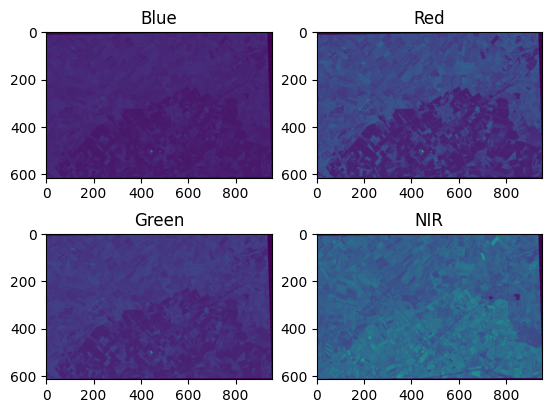

In [8]:
# Display the different bands
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(blue)
axs[0, 0].set_title("Blue")
axs[1, 0].imshow(green)
axs[1, 0].set_title("Green")
axs[0, 1].imshow(red)
axs[0, 1].set_title("Red")
axs[1, 1].imshow(nir)
axs[1, 1].set_title("NIR")

In [9]:
# Create an RGB (Red, Green, Blue) composite
rgb_image = np.dstack((red, green, blue))
# Display image dimensions and check 3 bands have stacked properly.
rgb_image.shape

(614, 952, 3)

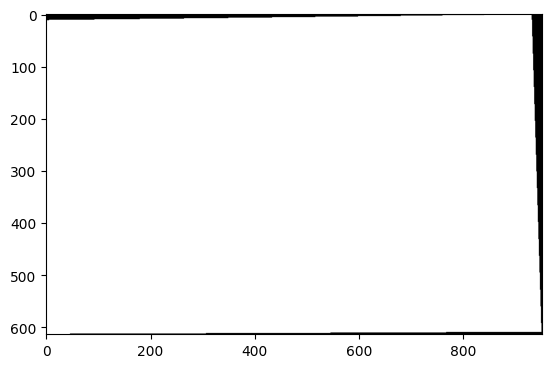

In [10]:
# Display the RGB image
plt.imshow(rgb_image)

In [11]:
# Find the maximum and minimum value for pixels e.g.
blue.max()

np.uint16(18816)

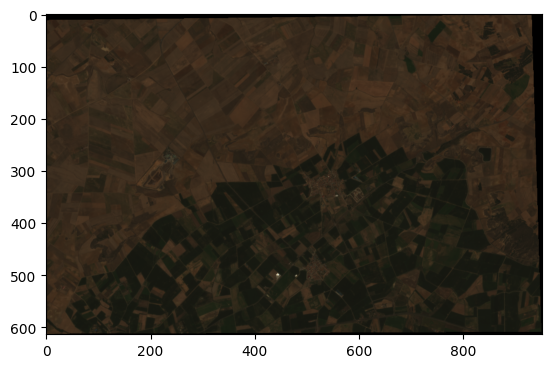

In [13]:
# Normalize and display the image
def normalize(band):
  band_min, band_max = (band.min(), band.max())
  return ((band-band_min)/((band_max - band_min)))
red_n = normalize(red)
green_n = normalize(green)
blue_n = normalize(blue)
rgb_composite_n= np.dstack((red_n, green_n, blue_n))
plt.imshow(rgb_composite_n)

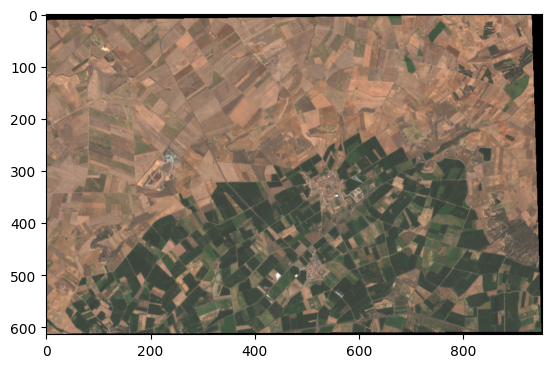

In [15]:
# Function to brighten the image. Brightness will be between 0 and 255.
def brighten(band):
  alpha=0.05
  beta=0
  return np.clip(alpha*band+beta, 0,255)
red_b=brighten(red)
blue_b=brighten(blue)
green_b=brighten(green)
# Normalize the brightened bands and display the image
red_bn = normalize(red_b)
green_bn = normalize(green_b)
blue_bn = normalize(blue_b)
rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
plt.imshow(rgb_composite_bn)

In [20]:
# Suppress errors
np.seterr(divide='ignore', invalid='ignore')
# Feature Selection: Vegetation Indices
# Create the index (NDVI)
ndvi = (nir.astype(float) - red.astype(float)) / (nir.astype(float) +
red.astype(float))
# Remove pixels without a number
ndvi_mask = np.ma.masked_array(ndvi, np.isnan(ndvi))
gci = (nir.astype(float) / green.astype(float)) - 1
gci_mask = np.ma.masked_array(gci, np.isnan(gci))
savi = (1.5 * (nir.astype(float) - red.astype(float))) / (nir.astype(float) + red.astype(float) + 0.5)
# Remove pixels without a number
ndvi_mask = np.ma.masked_array(ndvi, np.isnan(ndvi))
gci = (nir.astype(float) / green.astype(float)) - 1
gci_mask = np.ma.masked_array(gci, np.isnan(gci))
savi = (1.5 * (nir.astype(float) - red.astype(float))) / (nir.astype(float) + red.astype(float) + 0.5)
savi_mask = np.ma.masked_array(savi, np.isnan(savi))

In [21]:
# Print max NDVI value disregarding masked values
max_ndvi_masked = ndvi_mask.max()
print("maximum NDVI (masked): ", max_ndvi_masked)
# Print min NDVI value disregarding the masked values
min_ndvi_masked = ndvi_mask.min()
print("minimum NDVI (masked): ", min_ndvi_masked)

maximum NDVI (masked):  0.727683734623068
minimum NDVI (masked):  -0.14285714285714285


Text(0.5, 1.0, 'Normalized Difference Vegetation Index - NDVI')

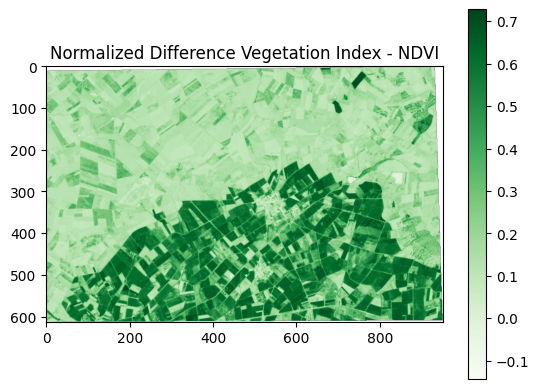

In [22]:
# NDVI
plt.imshow(ndvi, cmap = "Greens")
plt.colorbar()
plt.title('Normalized Difference Vegetation Index - NDVI')

Text(0.5, 1.0, 'Green Chlorophyll Index - GCI')

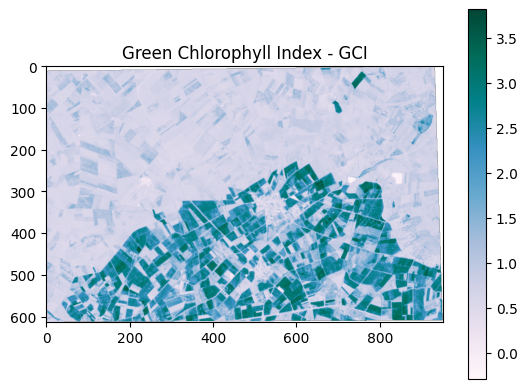

In [23]:
# GCI
plt.imshow(gci, cmap = "PuBuGn")
plt.colorbar()
plt.title('Green Chlorophyll Index - GCI')

Text(0.5, 1.0, 'Soil Adjusted Vegetation Index - SAVI')

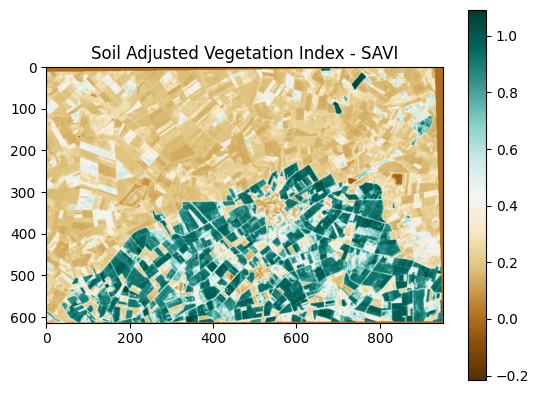

In [24]:
# SAVI
plt.imshow(savi, cmap = "BrBG")
plt.colorbar()
plt.title('Soil Adjusted Vegetation Index - SAVI')

<Axes: >

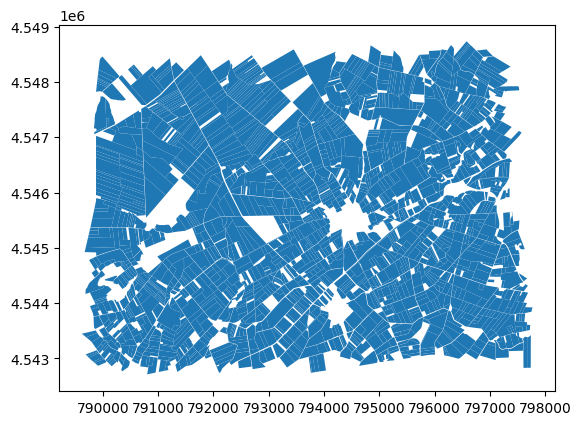

In [25]:
# Creating a simple map from shapefile
parcels.plot()

<Axes: >

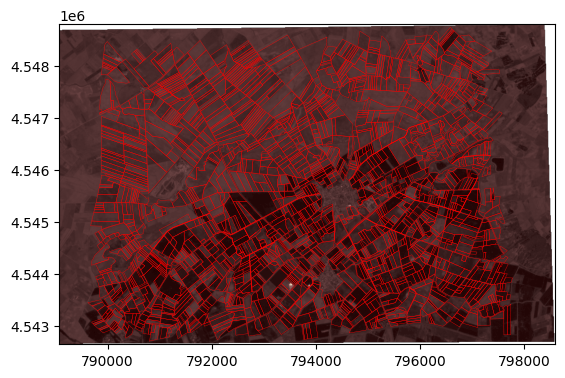

In [26]:
# To overlay the shapefile and raster image we have to use rasterio
s2 = rasterio.open('Sentinel2.tif')
fig, ax = plt.subplots()
# Transform rasterio plot to real world coords
extent = [s2.bounds[0], s2.bounds[2], s2.bounds[1], s2.bounds[3]]
ax = rasterio.plot.show(s2, extent=extent, ax=ax, cmap="pink")
parcels.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.25)

In [40]:
# To run zonal statistics, we will save the different vegetation indices to GeoTIFF files
# NDVI
# Get GeoTIFF driver and make a new GeoTiff file for NDVI, specifying the size
ndvi_out = gdal.GetDriverByName("GTiff").Create("NDVI.tif", cols, rows, 1,
gdal.GDT_Float32)

# Provide the coordinates and resolution (geospatial transformation). We printed this array in section 7 – Open Raster and Shapefile
ndvi_out.SetGeoTransform(geom_transform)
# Provide the projection – the spatial reference system - for the image. We printed this in section 7 – Open Raster and Shapefile
ndvi_out.SetProjection(projection)
# Write the NDVI data to the file
ndvi_out.WriteArray(ndvi)


# Fully save the file (GDAL can keep some information in memory)
ndvi_out.FlushCache()
# Close the file
ndvi_out = None

# GCI
gci_out = gdal.GetDriverByName("GTiff").Create("GCI.tif", cols, rows, 1,
gdal.GDT_Float32)
gci_out.SetGeoTransform(geom_transform)
gci_out.SetProjection(projection)
gci_out.WriteArray(gci)
gci_out.FlushCache()
gci_out = None
# SAVI
savi_out = gdal.GetDriverByName("GTiff").Create("SAVI.tif", cols, rows, 1,
gdal.GDT_Float32)
savi_out.SetGeoTransform(geom_transform)
savi_out.SetProjection(projection)
savi_out.WriteArray(savi)
savi_out.FlushCache()
savi_out = None

In [69]:
import os
import csv
import numpy as np
from osgeo import gdal, ogr

# Zonal Statistics:
# -----------------
# Functions to align shapefile and raster (TIF)
def boundingBoxToOffsets(bbox, geot):
    col1 = int((bbox[0] - geot[0]) / geot[1])
    col2 = int((bbox[1] - geot[0]) / geot[1]) + 1
    row1 = int((bbox[3] - geot[3]) / geot[5])
    row2 = int((bbox[2] - geot[3]) / geot[5]) + 1
    return [row1, row2, col1, col2]

def geotFromOffsets(row_offset, col_offset, geot):
    new_geot = [
        geot[0] + (col_offset * geot[1]),
        geot[1],
        0.0,
        geot[3] + (row_offset * geot[5]),
        0.0,
        geot[5]
    ]
    return new_geot

# Function to calculate statistics and return feature data
def setFeatureStats(fid, mean, median, sd, names=["mean", "median", "sd", "id"]):
    featstats = {
        names[0]: mean,
        names[1]: median,
        names[2]: sd,
        names[3]: fid,
    }
    return featstats

# Open raster and shapefile
mem_driver = ogr.GetDriverByName("Memory")
mem_driver_gdal = gdal.GetDriverByName("MEM")

shp_name = "temp"
fn_raster = "GCI.tif"
fn_zones = "Parcel_LandUse_Final.shp"

r_ds = gdal.Open(fn_raster)
p_ds = ogr.Open(fn_zones)
lyr = p_ds.GetLayer()

geot = r_ds.GetGeoTransform()
nodata = r_ds.GetRasterBand(1).GetNoDataValue()

zstats = []

# Loop through each parcel
p_feat = lyr.GetNextFeature()
while p_feat:
    if p_feat.GetGeometryRef() is not None:
        if os.path.exists(shp_name):
            mem_driver.DeleteDataSource(shp_name)

        tp_ds = mem_driver.CreateDataSource(shp_name)
        tp_lyr = tp_ds.CreateLayer('polygons', None, ogr.wkbPolygon)
        tp_lyr.CreateFeature(p_feat.Clone())

        offsets = boundingBoxToOffsets(p_feat.GetGeometryRef().GetEnvelope(), geot)
        new_geot = geotFromOffsets(offsets[0], offsets[2], geot)

        tr_ds = mem_driver_gdal.Create(
            "",
            offsets[3] - offsets[2],
            offsets[1] - offsets[0],
            1,
            gdal.GDT_Byte
        )
        tr_ds.SetGeoTransform(new_geot)
        gdal.RasterizeLayer(tr_ds, [1], tp_lyr, burn_values=[1])

        tr_array = tr_ds.ReadAsArray()
        r_array = r_ds.GetRasterBand(1).ReadAsArray(
            offsets[2],
            offsets[0],
            offsets[3] - offsets[2],
            offsets[1] - offsets[0]
        )

        fid = p_feat.GetFID()

        if r_array is not None:
            maskarray = np.ma.MaskedArray(
                r_array,
                np.logical_or(r_array == nodata, np.logical_not(tr_array))
            )
            if maskarray.count() > 0:
                zstats.append(setFeatureStats(
                    fid,
                    maskarray.mean(),
                    np.ma.median(maskarray),
                    maskarray.std()
                ))
            else:
                zstats.append(setFeatureStats(fid, nodata, nodata, nodata))
        else:
            zstats.append(setFeatureStats(fid, nodata, nodata, nodata))

        # Cleanup
        tp_ds = None
        tp_lyr = None
        tr_ds = None

    p_feat = lyr.GetNextFeature()

# Save zonal statistics to CSV
fn_csv = "GCI_zstats.csv"
col_names = zstats[0].keys()

with open(fn_csv, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=col_names)
    writer.writeheader()
    writer.writerows(zstats)

In [70]:
# Open CSV file
ndvi_df = pd.read_csv("NDVI_zstats.csv")
savi_df = pd.read_csv("SAVI_zstats.csv")
gci_df = pd.read_csv("GCI_zstats.csv")

# Rename columns
ndvi_df.rename(columns={"mean": "NDVI_mean", "median": "NDVI_median", "sd":
"NDVI_sd"}, inplace=True)
savi_df.rename(columns={"mean": "SAVI_mean", "median": "SAVI_median", "sd":
"SAVI_sd"}, inplace=True)
gci_df.rename(columns={"mean": "GCI_mean", "median": "GCI_median", "sd":
"GCI_sd"}, inplace=True)

# Transform the geodataframe to dataframe and join all of them
# Then for the conversion, I drop the last column (geometry) and specify the column names for the new df
parcels_df = pd.DataFrame(parcels.iloc[:,:-1].values,
columns=list(parcels.columns.values)[:-1])

# Combine dataframes
vi_df = pd.concat([ndvi_df["NDVI_mean"], savi_df["SAVI_mean"],
gci_df["GCI_mean"]], axis=1)
df = pd.concat([parcels_df.rename(columns={"MAJORITY": "LUSE_CODE"}),
ndvi_df.drop(columns=['id']), savi_df.drop(columns=['id']),
gci_df.drop(columns=['id'])], axis=1)

In [71]:
# Random Forest Model
# -------------------
X = vi_df
y = df["LUSE_CODE"].astype("int")
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [72]:
# Fitting and Evaluating the Model
rf = RandomForestClassifier(n_estimators=1000, max_depth=10,
max_features='log2', min_samples_leaf=20, min_samples_split=2)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=20,
                       n_estimators=1000)

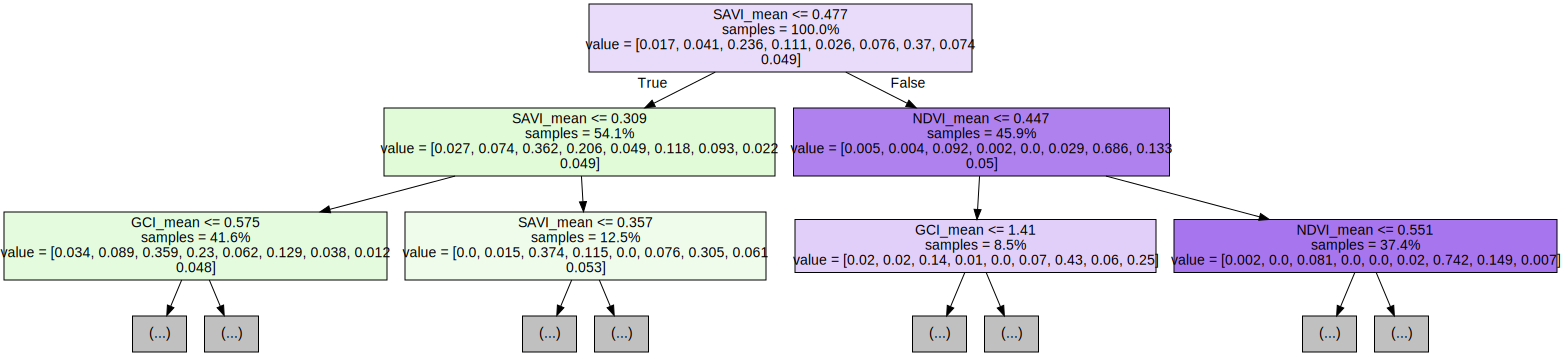

In [73]:
# Visualizing the results:
# Export the first three decision trees from the forest
for i in range(3):
  tree = rf.estimators_[i]
  dot_data = export_graphviz(tree,
    feature_names=X_train.columns,
    filled=True,
    max_depth=2,
    impurity=False,
    proportion=True)
graph = graphviz.Source(dot_data)
display(graph)

In [75]:
# We have trained a Random Forest model, but we need to find out whether it
# is making accurate predictions
y_pred = rf.predict(X_test)
# Extract and display metrics
avg_f1_score = f1_score(y_test, y_pred, average="weighted")
accuracy = accuracy_score(y_test, y_pred)
print("Classification accuracy {:.1f}%".format(100 * accuracy))
print("Classification F1-score {:.1f}%".format(100 * avg_f1_score))

avg_f1_score = f1_score(y_test, y_pred, average="weighted")
accuracy = accuracy_score(y_test, y_pred)
print("Classification accuracy {:.1f}%".format(100 * accuracy))
print("Classification F1-score {:.1f}%".format(100 * avg_f1_score))

Classification accuracy 51.6%
Classification F1-score 44.3%
Classification accuracy 51.6%
Classification F1-score 44.3%


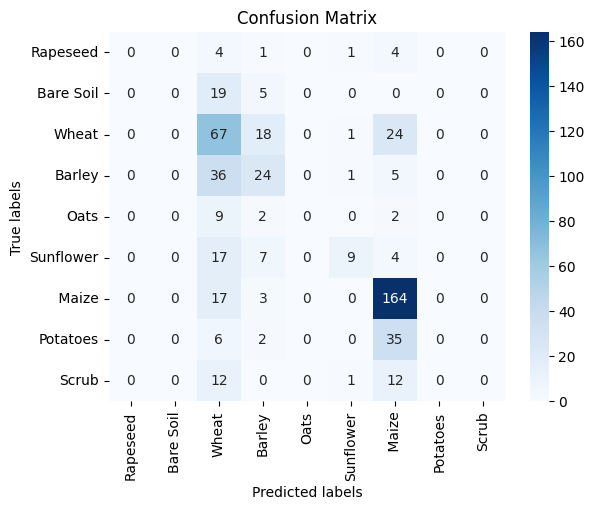

In [76]:
# Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Rapeseed', 'Bare Soil', 'Wheat', 'Barley', 'Oats',
'Sunflower', ' Maize', 'Potatoes', 'Scrub'], rotation=90);
ax.yaxis.set_ticklabels(['Rapeseed', 'Bare Soil', 'Wheat', 'Barley', 'Oats',
'Sunflower', ' Maize', 'Potatoes', 'Scrub'], rotation=0);

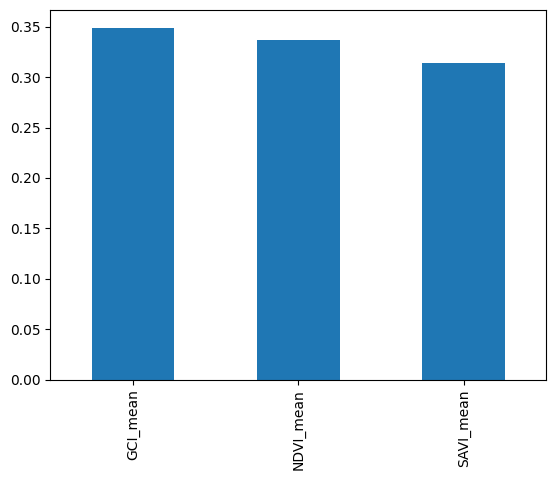

In [78]:
# Create a series containing feature importances from the model and feature
# names from the training data
feature_importances = pd.Series(rf.feature_importances_,
                                index=X_train.columns).sort_values(ascending=False)
# Plot a simple bar chart
feature_importances.plot.bar();
# Plot a simple bar chart
feature_importances.plot.bar();